In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
longbeach = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-03-04/longbeach.csv')

df = longbeach.copy()

In [6]:
#converting to date columns
df["intake_date"] = pd.to_datetime(df["intake_date"], errors="coerce")
df["outcome_date"] = pd.to_datetime(df["outcome_date"], errors="coerce")
df["dob"] = pd.to_datetime(df["dob"], errors="coerce")

In [7]:
#calculating stay lenght
df["stay_in_months"] = np.where(
    df["outcome_date"].isna(),  # Condition: if dob is NaT (missing)
    np.nan,             # Value if True: assign NaN
    (df["outcome_date"].dt.to_period("M").astype(int) - df["intake_date"].dt.to_period("M").astype(int))  # Value if False: calculate age
)

In [8]:
#calculating age at intake
df["age_at_intake"] = np.where(
    df["dob"].isna(),  # Condition: if dob is NaT (missing)
    np.nan,             # Value if True: assign NaN
    (df["intake_date"].dt.to_period("Y").astype(int) - df["dob"].dt.to_period("Y").astype(int))  # Value if False: calculate age
)

In [9]:
#negative values detected, fixing wrong dob
df.loc[df['age_at_intake'] < 0, 'dob'] = pd.to_datetime('2015-01-01')

In [10]:
#checking for missing values -> there are missing values, but the crucial ones are there
df.isna().sum()

animal_id                0
animal_name          12162
animal_type              0
primary_color            0
secondary_color      15604
sex                      0
dob                   3591
intake_date              0
intake_condition         0
intake_type              0
intake_subtype         390
reason_for_intake    27784
outcome_date           177
crossing                 0
jurisdiction             1
outcome_type           187
outcome_subtype       3386
latitude                 0
longitude                0
outcome_is_dead          0
was_outcome_alive        0
geopoint                 0
stay_in_months         177
age_at_intake         3591
dtype: int64

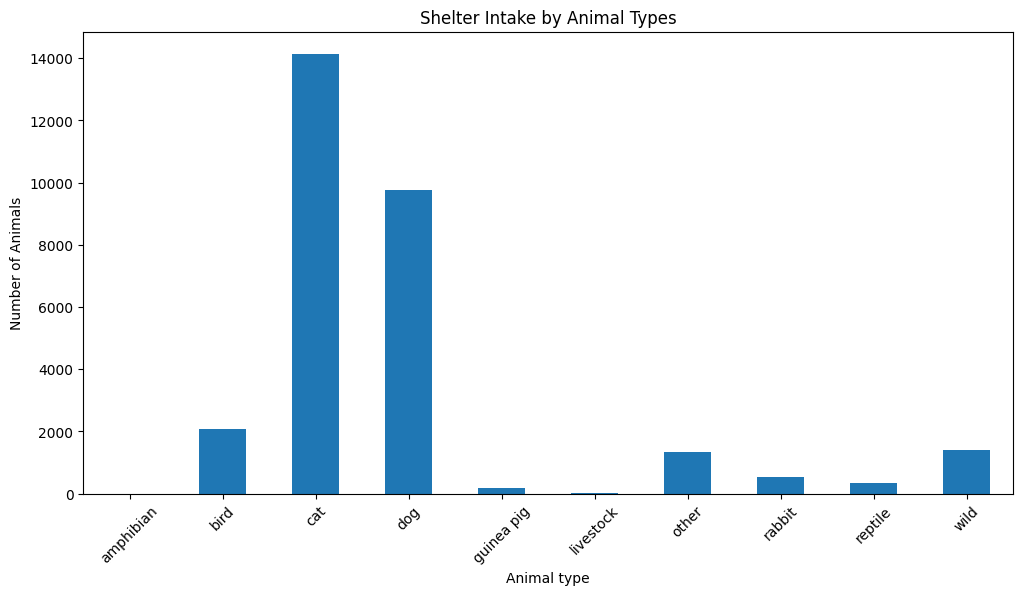

In [11]:
df.groupby('animal_type').size().plot(kind='bar', figsize=(12, 6))
plt.title('Shelter Intake by Animal Types')
plt.xlabel('Animal type')
plt.ylabel('Number of Animals')
plt.xticks(rotation=45)
plt.show()

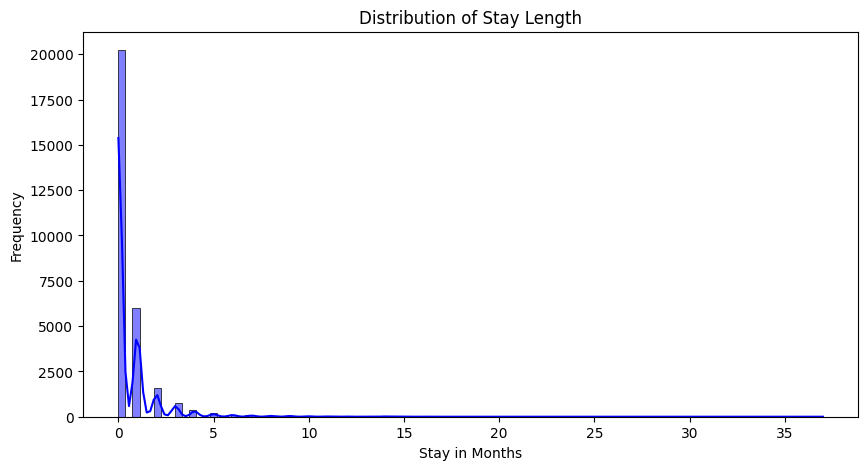

In [12]:
#histogram with lenght of stays
plt.figure(figsize=(10, 5))
sns.histplot(df["stay_in_months"], bins=100, kde=True, color="blue")
plt.title("Distribution of Stay Length")
plt.xlabel("Stay in Months")
plt.ylabel("Frequency")
plt.show()

In [14]:
#creating subset with animals that left the shelter
df_gone = df[~df["outcome_date"].isna()]

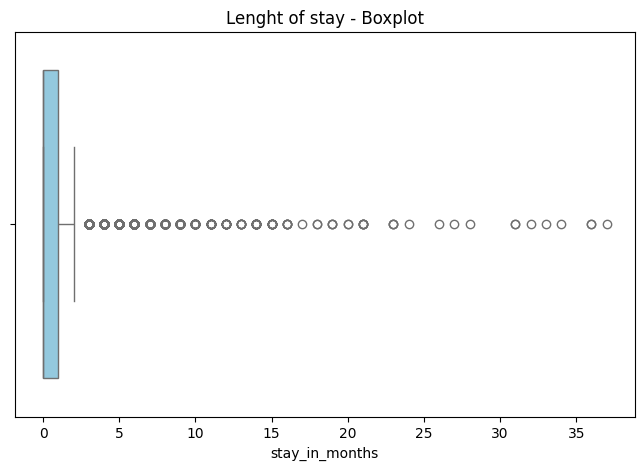

In [15]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_gone["stay_in_months"], color="skyblue")
plt.xlabel("stay_in_months")
plt.title("Lenght of stay - Boxplot")
plt.show()

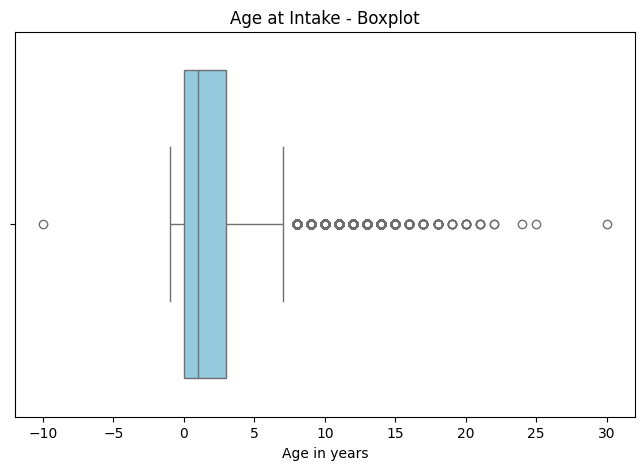

In [16]:
#age at intake boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["age_at_intake"], color="skyblue")
plt.xlabel("Age in years")
plt.title("Age at Intake - Boxplot")
plt.show()

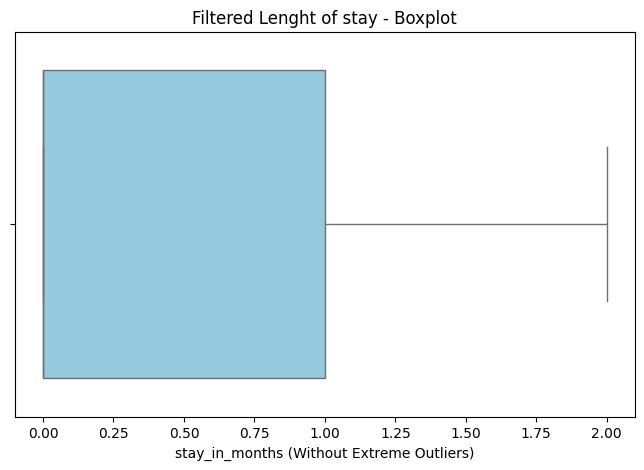

In [17]:
#removing outliers for cleaner view
Q1 = df_gone["stay_in_months"].quantile(0.05)
Q3 = df_gone["stay_in_months"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df_gone[(df_gone["stay_in_months"] >= lower_bound) & (df_gone["stay_in_months"] <= upper_bound)]

plt.figure(figsize=(8, 5))
sns.boxplot(x=df_filtered["stay_in_months"], color="skyblue")
plt.xlabel("stay_in_months (Without Extreme Outliers)")
plt.title("Filtered Lenght of stay - Boxplot")
plt.show()

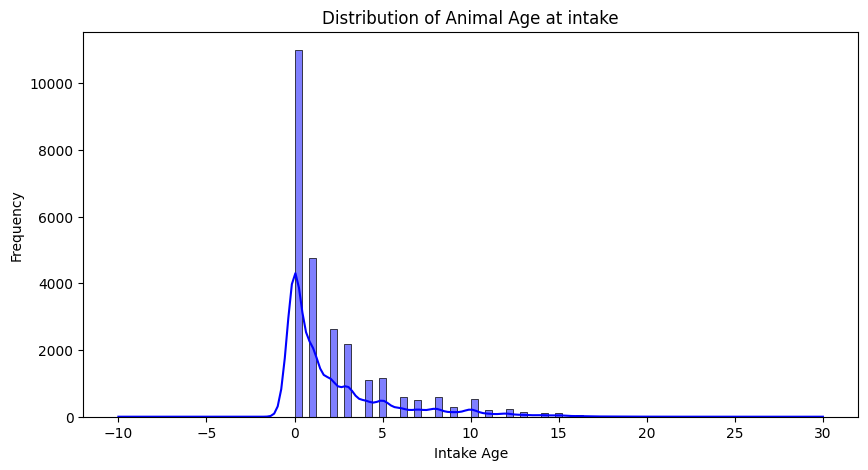

In [18]:
#animal age at intake
plt.figure(figsize=(10, 5))
sns.histplot(df["age_at_intake"], bins=100, kde=True, color="blue")
plt.title("Distribution of Animal Age at intake")
plt.xlabel("Intake Age")
plt.ylabel("Frequency")
plt.show()

In [19]:
cross_age = pd.crosstab(df['animal_type'], df['age_at_intake'])

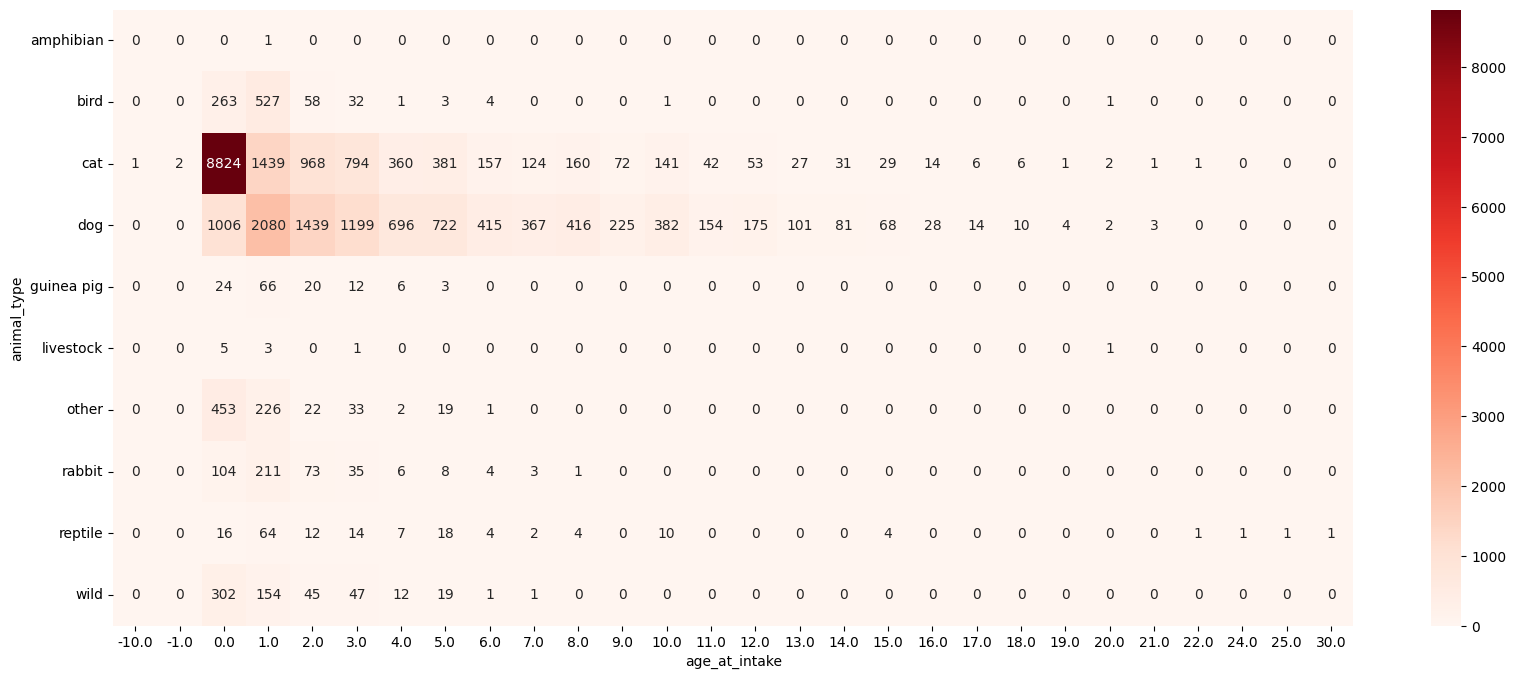

In [20]:
plt.figure(figsize=(20, 8))
sns.heatmap(cross_age, annot=True, cmap="Reds", fmt="d")
plt.show()

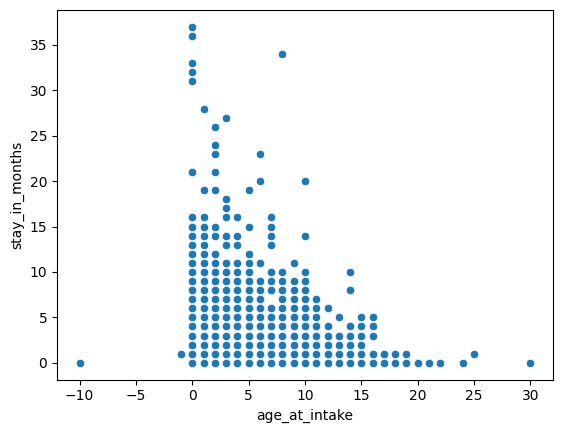

In [21]:
sns.scatterplot(data=df, x='age_at_intake', y='stay_in_months')
plt.show()

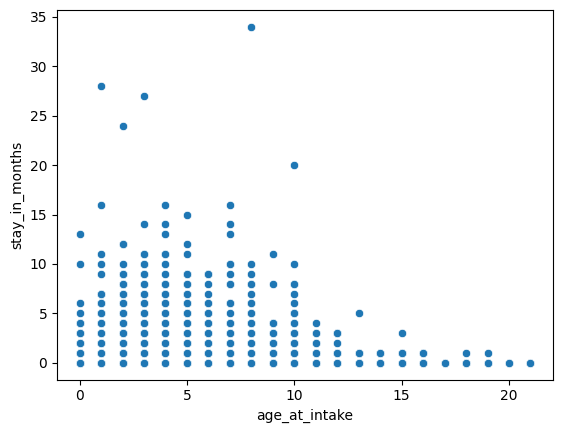

In [22]:
sns.scatterplot(data=df[df["animal_type"] == "dog"], x='age_at_intake', y='stay_in_months')
plt.show()

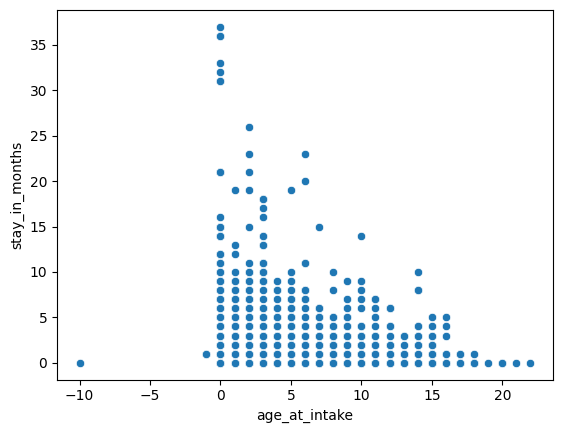

In [23]:
sns.scatterplot(data=df[df["animal_type"] == "cat"], x='age_at_intake', y='stay_in_months')
plt.show()

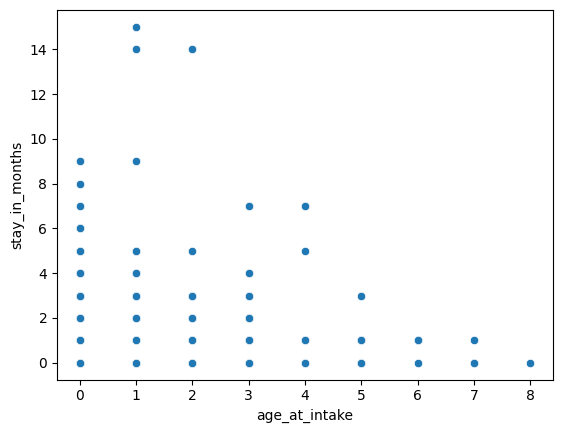

In [24]:
sns.scatterplot(data=df[df["animal_type"] == "rabbit"], x='age_at_intake', y='stay_in_months')
plt.show()

In [25]:
#creating age buckets 

def categorize_age(age):
    if pd.isna(age):
        return 'Unknown'
    elif age <= 1:
        return '1 year and under'
    elif age > 1 and age < 3:
        return '1-3 years'
    elif age >= 3 and age < 8:
        return '3-8 years'
    elif age >= 8 and age < 15:
        return '8-15 years'
    else:
        return '15 and older'

# Apply the function to the 'age' column
df['age_category'] = df['age_at_intake'].apply(categorize_age)

In [26]:
cross_cat_age = pd.crosstab(df['age_category'], df['outcome_type'])

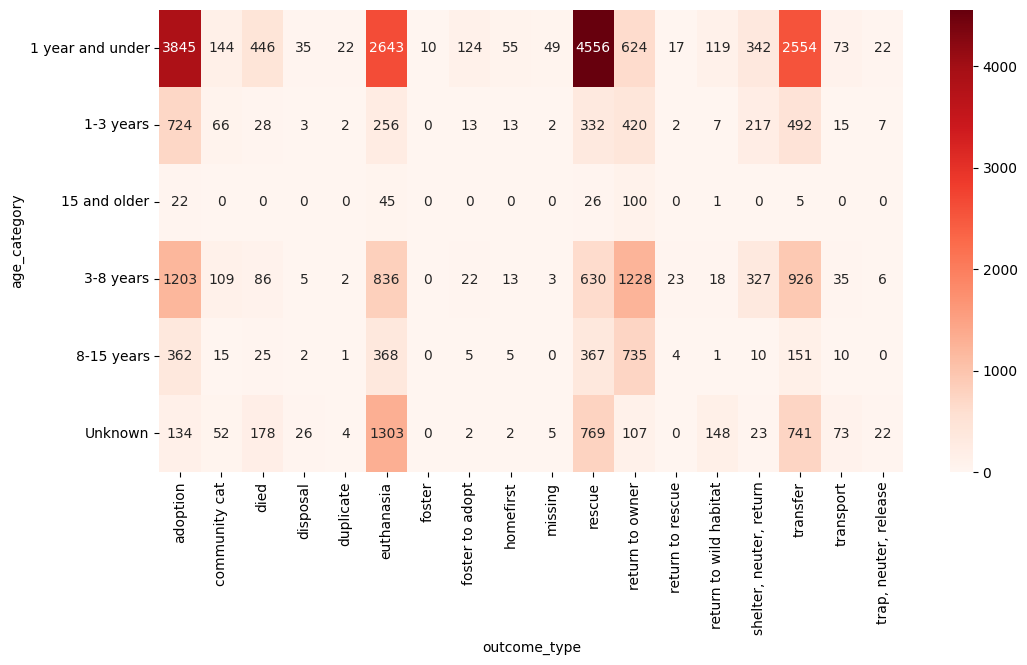

In [27]:
plt.figure(figsize=(12, 6))
sns.heatmap(cross_cat_age, annot=True, cmap="Reds", fmt="d")
plt.show()

In [28]:
cross_output = pd.crosstab(df_gone['animal_type'], df['outcome_type'])

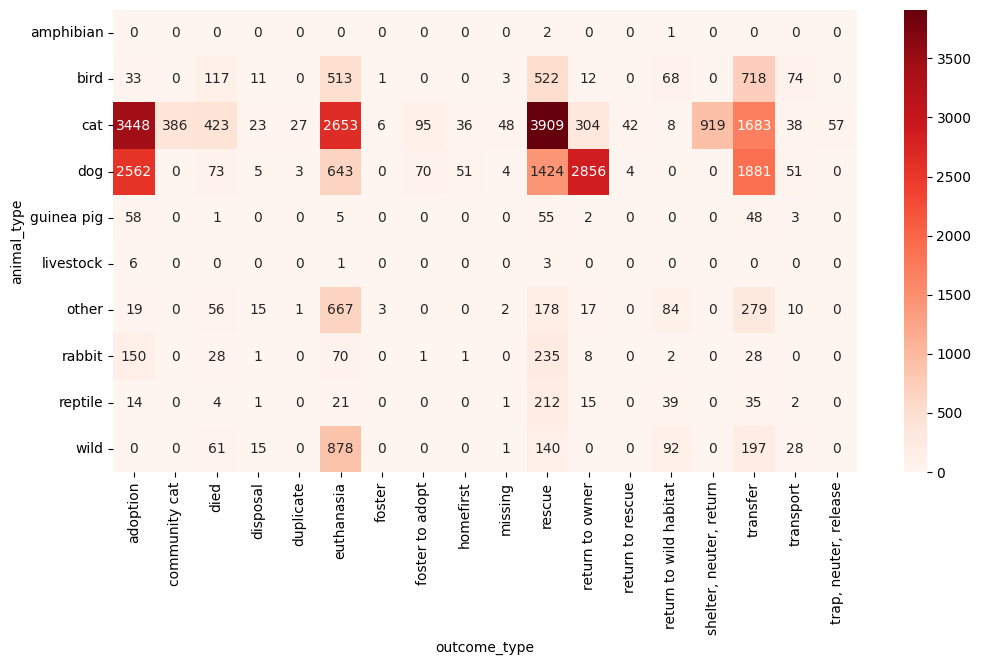

In [29]:
plt.figure(figsize=(12, 6))
sns.heatmap(cross_output, annot=True, cmap="Reds", fmt="d")
plt.show()

In [30]:
#Adoption Rate Analysis by animal type
adoption_rate_by_animal_type = df.groupby("animal_type").agg(
    adoption_rate=pd.NamedAgg(
        column="outcome_type",
        aggfunc=lambda x: (x == "adoption").sum() / len(x)
    )
).reset_index()

/var/folders/8m/yz8tmn5d3ns2cwtr98zklxtw0000gn/T/ipykernel_67023/4000075773.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/8m/yz8tmn5d3ns2cwtr98zklxtw0000gn/T/ipykernel_67023/4000075773.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(tick * 100)}%' for tick in plt.gca().get_yticks()])


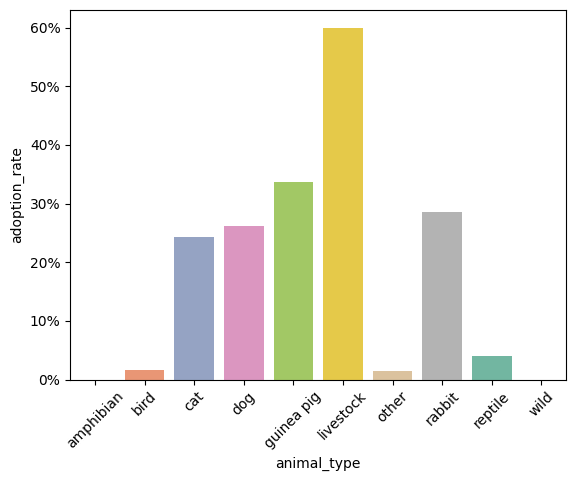

In [31]:
sns.barplot(
    x='animal_type',
    y='adoption_rate',
    data=adoption_rate_by_animal_type,
    palette='Set2',
)
plt.gca().set_yticklabels([f'{int(tick * 100)}%' for tick in plt.gca().get_yticks()])
plt.xticks(rotation=45)
plt.show()

In [34]:
df["intake_month"] = df['intake_date'].dt.month
df["intake_year"] = df['intake_date'].dt.year
df_time = df.groupby(["intake_year","intake_month"])["animal_id"].count().reset_index()
df_time.rename(columns={"animal_id": "intake_count"},inplace=True)
df_time_pivot = df_time.pivot(index='intake_month', columns='intake_year',values='intake_count')
df_time_pivot = df_time_pivot.reset_index()


In [36]:
df_series = df_time_pivot.set_index('intake_month').stack()
df_series.index = pd.to_datetime([f'{year}-{month:02d}-01' for month, year in df_series.index])

/var/folders/8m/yz8tmn5d3ns2cwtr98zklxtw0000gn/T/ipykernel_67023/2053554584.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_season, x='month', y='count', palette='viridis')


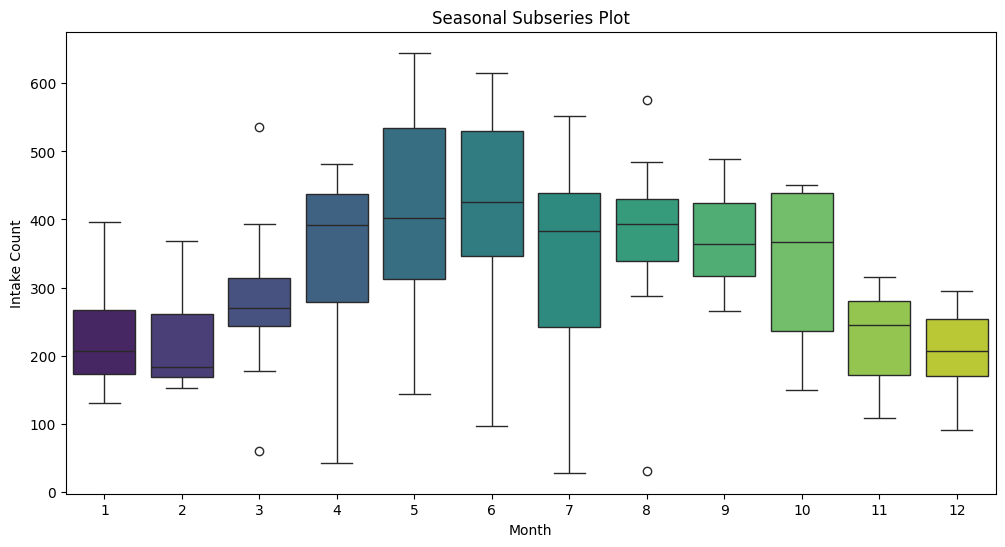

In [37]:
# seasonal boxplots
df_season = df_series.reset_index()
df_season.columns = ['date', 'count']
df_season['month'] = df_season['date'].dt.month

# Boxplot for seasonal effect
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_season, x='month', y='count', palette='viridis')
plt.title('Seasonal Subseries Plot')
plt.xlabel('Month')
plt.ylabel('Intake Count')
plt.show()

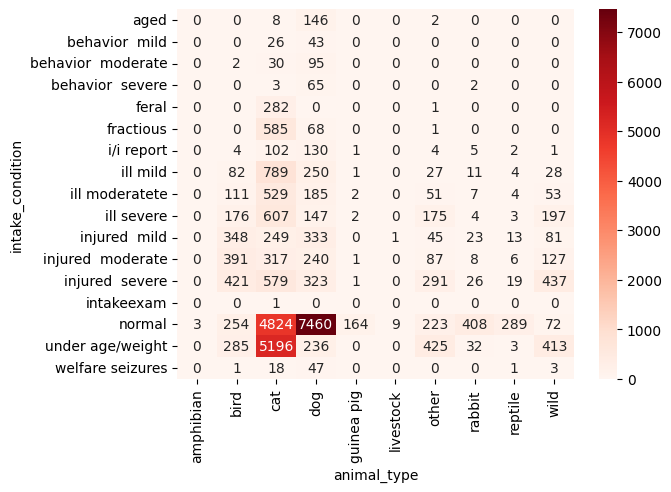

In [38]:
cross_cat_intake = pd.crosstab(df['intake_condition'], df['animal_type'])
sns.heatmap(cross_cat_intake, annot=True, cmap="Reds", fmt="d")
plt.show()

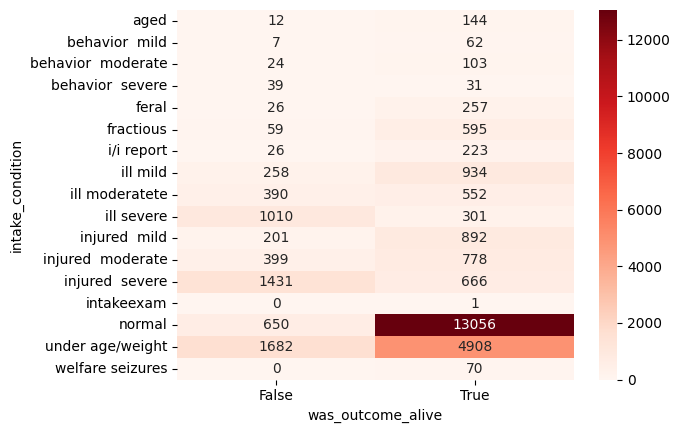

In [39]:
cross_cat_survival = pd.crosstab(df['intake_condition'], df['was_outcome_alive'])
sns.heatmap(cross_cat_survival, annot=True, cmap="Reds", fmt="d")
plt.show()

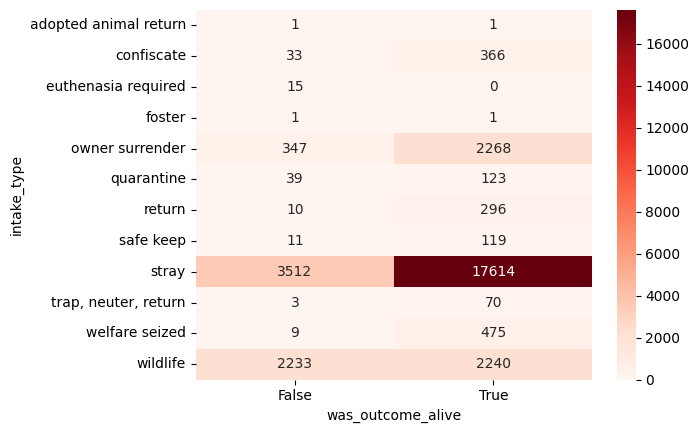

In [41]:
cross_type_survival = pd.crosstab(df['intake_type'], df['was_outcome_alive'])
sns.heatmap(cross_type_survival, annot=True, cmap="Reds", fmt="d")
plt.show()

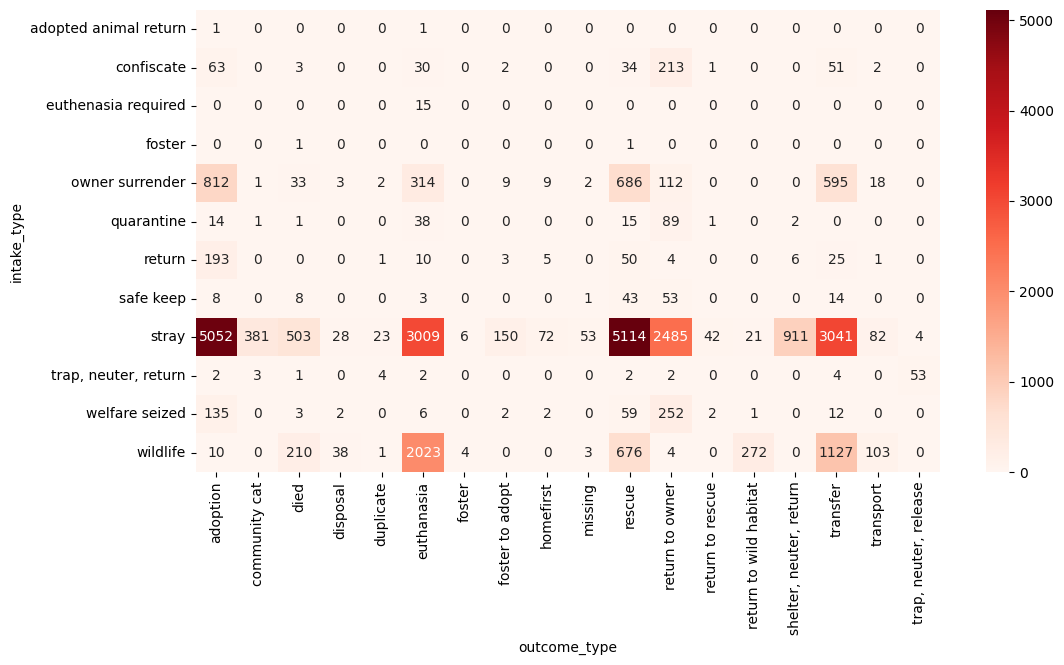

In [42]:
cross_intake_outcome = pd.crosstab(df['intake_type'], df['outcome_type'])
plt.figure(figsize=(12, 6))
sns.heatmap(cross_intake_outcome, annot=True, cmap="Reds", fmt="d")
plt.show()

In [43]:
df_runners = df[df["outcome_type"] == 'return to owner']

In [44]:
df_runners["animal_type"].value_counts()

animal_type
dog           2856
cat            304
other           17
reptile         15
bird            12
rabbit           8
guinea pig       2
Name: count, dtype: int64

In [45]:
round(df_runners.groupby("animal_type")["stay_in_months"].mean(),2)

animal_type
bird          0.17
cat           0.24
dog           0.11
guinea pig    0.50
other         0.00
rabbit        0.00
reptile       0.00
Name: stay_in_months, dtype: float64

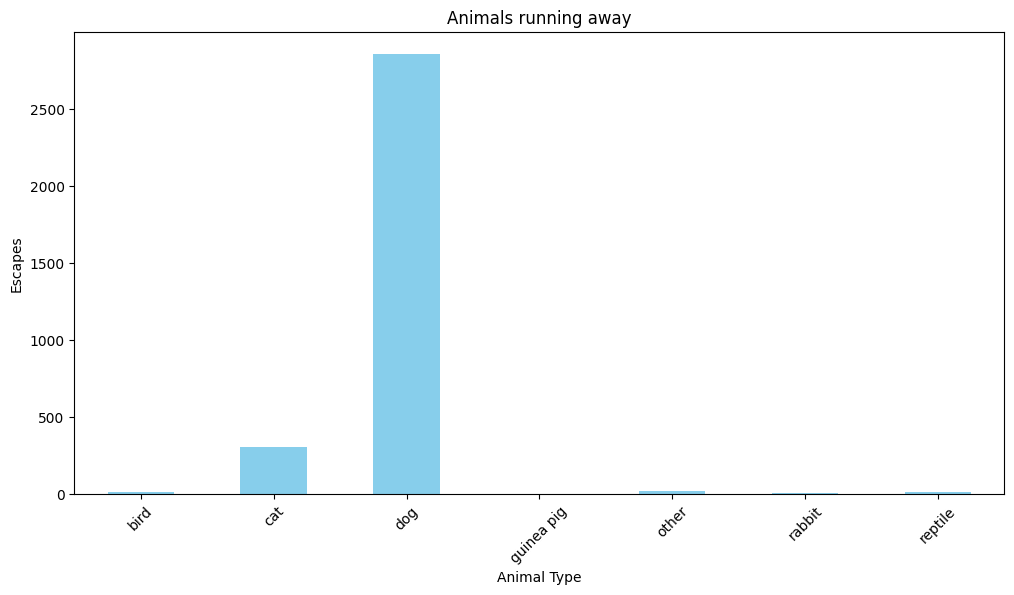

In [46]:
df_runners.groupby('animal_type').size().plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Animals running away')
plt.xlabel('Animal Type')
plt.ylabel('Escapes')
plt.xticks(rotation=45)
plt.show()

In [47]:
#longest tenure award
df[df["stay_in_months"] == 37]

,animal_id,animal_name,animal_type,primary_color,secondary_color,sex,dob,intake_date,intake_condition,intake_type,intake_subtype,reason_for_intake,outcome_date,crossing,jurisdiction,outcome_type,outcome_subtype,latitude,longitude,outcome_is_dead,was_outcome_alive,geopoint,stay_in_months,age_at_intake,age_category,intake_month,intake_year
1053,A629132,macy,cat,gray tabby,NaN,Female,2019-03-30,2019-06-29,normal,stray,otc,NaN,2022-07-10,"10TH ST / LINDEN AVE, LONG BEACH, CA 90813",Long Beach,adoption,NaN,33.778972,-118.186368,False,True,"33.7789716, -118.1863682",37.0,0.0,1 year and under,6,2019
